
CS7180 - Advanced Perception

Image Enhancement Proj 1

20th September 2023

By

> Anirudh Muthuswamy, NUID - 002783250


> Gugan Kathiresan, NUID - 002756523



# Requirements - Libraries and Module Installation

In [ ]:
!pip install patchify
!pip install torchviz
!pip install torchsummary

  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4130 sha256=297c068b1d3e79b3126c9265a1b2a9b70ebcc86a53c222e4fde994328d941903
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


# Import Libraries

In [ ]:
from PIL import Image
from tqdm import tqdm
import time
import patchify

import pandas as pd
import glob as glob
import os
import cv2
import math

import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision.utils import save_image
plt.style.use('ggplot')
from torch.utils.data import DataLoader, Dataset
import torchvision.models as models

import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
from torchviz import make_dot
from torchsummary import summary

## Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Prepare files

## Unzipping the DIV2k2017 Dataset

In [ ]:
!unzip '/content/drive/MyDrive/Copy of DIV2K2017.zip'

## Generating Patches from the High Resolution images.

These patches are basically sub-images of the original image.

*(Serves the aim of super-resolution:
 picking out small regions of the original image, blowing it up and improving the resolution on that.)*

In [ ]:
''' Function to store the high resolution patches, i.e, sub-images in the specified folder.
 High resolution images are simple patches of the original image of size 32x32 moved over the
 original image with a stride of 14.'''

def create_high_res_patches(patch_path, patch_size, stride, image_paths, images):

  os.makedirs(patch_path, exist_ok = True)

  print("Number of images in directory:", len(image_paths))

  breaktime = 0
  for image_path in image_paths:
      breaktime += 1
      ''' Obtaining the image'''
      input_image = Image.open(image_path)
      image_name = image_path.split(os.path.sep)[-1].split('.')[0]
      print(" Image name:", image_name)

      ''' Passing to patchify function'''
      high_res_patches = patchify.patchify(np.array(input_image), patch_size, stride)
      print(" \tImage size:", high_res_patches.shape)

      '''Reading the patches generated and saving individually'''
      counter = 0
      for i in range(high_res_patches.shape[0]):
          for j in range(high_res_patches.shape[1]):
              counter +=1
              patch = high_res_patches[i, j, 0, :, :, :]
              patch = cv2.cvtColor(patch, cv2.COLOR_RGB2BGR)
              cv2.imwrite(f"{patch_path}/{image_name}_{counter}.png",patch)

      ''' "breaktime" Used to control the number of images in our dataset.
       To use the full dataset set the breaktime to the number of images in the dataset.
       For testing purposes, we chose to pick only 5 images, hence images = 5.'''

      if breaktime == images:
        break

In [ ]:
''' Function to store the low resolution patches, i.e, sub-images that are
 generated from the high res patches.
 To acheive this we apply bilinear interpolation to high res patches and
 store the low res patches in a different directory.'''

def create_low_res_patches(patch_path, patch_size, stride, image_paths, images):

  os.makedirs(patch_path, exist_ok = True)
  breaktime = 0

  for image_path in image_paths:
      breaktime += 1
      ''' Obtaining the image'''
      input_image = Image.open(image_path)
      image_name = image_path.split(os.path.sep)[-1].split('.')[0]
      print(" Image name:", image_name)

      ''' Passing to patchify function'''
      high_res_patches = patchify.patchify(np.array(input_image), patch_size, stride)
      print(" \tImage size:", high_res_patches.shape)

      '''Reading the patches generated, applying Guassian Blur to reduce the quality,
        downsizing by half, resizing it back to the same size using bicubic interpolation
        and finally saving individually'''
      counter = 0
      for i in range(high_res_patches.shape[0]):
          for j in range(high_res_patches.shape[1]):
              counter = counter + 1
              patch = high_res_patches[i,j,0,:,:,:]
              patch = cv2.cvtColor(patch, cv2.COLOR_RGB2BGR)

              h = 32
              w = 32

              # patch_blurred = cv2.GaussianBlur(patch,(3,3),0)
              low_res_patch = cv2.resize(patch, (int(h*0.5), int(w*0.5)), interpolation=cv2.INTER_CUBIC)
              upscaled_patch = cv2.resize(low_res_patch, (h,w), interpolation=cv2.INTER_CUBIC)
              cv2.imwrite(f"{patch_path}/{image_name}_{counter}.png",upscaled_patch)

      if breaktime == images:
        break

In [ ]:
stride = 14
patch_size = (32, 32, 3)
input_path = "DIV2K2017/DIV2K/DIV2K_train_HR"
image_extension = 'png'
image_paths = []
image_paths.extend(glob.glob(os.path.join(input_path, f'*.{image_extension}')))

print("Creating High Res Patches...")
create_high_res_patches("high_res_patches_5_Imgs", patch_size, stride, image_paths, 5)
print('')

print("Creating Low Res Patches...")
create_low_res_patches("low_res_patches_5_Imgs", patch_size, stride, image_paths, 5)
print('')

Creating High Res Patches...
Number of images in directory: 900
 Image name: 0840
 	Image size: (95, 144, 1, 32, 32, 3)
 Image name: 0506
 	Image size: (95, 144, 1, 32, 32, 3)
 Image name: 0317
 	Image size: (95, 144, 1, 32, 32, 3)
 Image name: 0886
 	Image size: (95, 144, 1, 32, 32, 3)
 Image name: 0445
 	Image size: (95, 144, 1, 32, 32, 3)

Creating Low Res Patches...
 Image name: 0840
 	Image size: (95, 144, 1, 32, 32, 3)
 Image name: 0506
 	Image size: (95, 144, 1, 32, 32, 3)
 Image name: 0317
 	Image size: (95, 144, 1, 32, 32, 3)
 Image name: 0886
 	Image size: (95, 144, 1, 32, 32, 3)
 Image name: 0445
 	Image size: (95, 144, 1, 32, 32, 3)



In [ ]:
''' Function to store the low resolution patches, i.e, sub-images that are
 generated from the high res patches.
 To acheive this we apply bilinear interpolation to high res patches and
 store the low res patches in a different directory.'''

def create_low_res_Images(low_res_image_path, image_paths, images):

  os.makedirs(low_res_image_path, exist_ok = True)
  breaktime = 0

  for image_path in image_paths:
      breaktime += 1
      ''' Obtaining the image'''
      print(image_path)
      input_image = cv2.imread(image_path)
      image_name = image_path.split(os.path.sep)[-1].split('.')[0]
      h = input_image.shape[1]
      w = input_image.shape[0]

      # image_blurred = cv2.GaussianBlur(input_image,(3,3),0)
      low_res_image = cv2.resize(input_image, (int(h*0.5), int(w*0.5)), interpolation=cv2.INTER_CUBIC)
      upscaled_image = cv2.resize(low_res_image, (h,w), interpolation=cv2.INTER_CUBIC)
      cv2.imwrite(f"{low_res_image_path}/{image_name}.png",upscaled_image)

      if breaktime == images:
        break

In [ ]:
print("Creating Low Res Images...")
create_low_res_Images("low_res_Images", image_paths, 50)
# create_low_res("low_res_patches_50_Imgs", patch_size, stride, image_paths, 50)
print('')

Creating Low Res Images...
DIV2K2017/DIV2K/DIV2K_train_HR/0840.png
DIV2K2017/DIV2K/DIV2K_train_HR/0506.png
DIV2K2017/DIV2K/DIV2K_train_HR/0317.png
DIV2K2017/DIV2K/DIV2K_train_HR/0886.png
DIV2K2017/DIV2K/DIV2K_train_HR/0445.png
DIV2K2017/DIV2K/DIV2K_train_HR/0479.png
DIV2K2017/DIV2K/DIV2K_train_HR/0282.png
DIV2K2017/DIV2K/DIV2K_train_HR/0586.png
DIV2K2017/DIV2K/DIV2K_train_HR/0070.png
DIV2K2017/DIV2K/DIV2K_train_HR/0612.png
DIV2K2017/DIV2K/DIV2K_train_HR/0882.png
DIV2K2017/DIV2K/DIV2K_train_HR/0781.png
DIV2K2017/DIV2K/DIV2K_train_HR/0327.png
DIV2K2017/DIV2K/DIV2K_train_HR/0817.png
DIV2K2017/DIV2K/DIV2K_train_HR/0716.png
DIV2K2017/DIV2K/DIV2K_train_HR/0391.png
DIV2K2017/DIV2K/DIV2K_train_HR/0396.png
DIV2K2017/DIV2K/DIV2K_train_HR/0477.png
DIV2K2017/DIV2K/DIV2K_train_HR/0118.png
DIV2K2017/DIV2K/DIV2K_train_HR/0602.png
DIV2K2017/DIV2K/DIV2K_train_HR/0898.png
DIV2K2017/DIV2K/DIV2K_train_HR/0534.png
DIV2K2017/DIV2K/DIV2K_train_HR/0095.png
DIV2K2017/DIV2K/DIV2K_train_HR/0303.png
DIV2K2017/DIV

## Train Test Split

In [ ]:
''' Function to get patched dataset details and generate a csv file for the train data.'''

def get_hrlr_split_patches(hr_path, lr_path, train_csv_path):
  print("Number of high res patches =", len(os.listdir(hr_path)))
  print("Number of low res patches =", len(os.listdir(lr_path)))

  y_filenames = os.listdir(hr_path)
  y_filenames = sorted(y_filenames)
  y_filenames = [hr_path + file for file in y_filenames]

  x_filenames = os.listdir(lr_path)
  x_filenames = sorted(x_filenames)
  x_filenames = [lr_path + file for file in x_filenames]

  ''' Adding all x filepaths == low res patches and y filepaths == high res patches to a dataframe.'''
  data = pd.DataFrame({'x_filepath':x_filenames, 'y_filepath':y_filenames})
  data_randomized = data.sample(frac=1, random_state=42).reset_index(drop=True)

  data_randomized.to_csv(train_csv_path, index = False)


In [ ]:
get_hrlr_split_patches('/content/high_res_patches_5_Imgs/', '/content/low_res_patches_5_Imgs/',
                'train_data_5_Imgs_patched.csv')

Number of high res patches = 68400
Number of low res patches = 68400


In [ ]:
# creating test csv for validating model with 50 low resolution images

''' Function to get low res Image dataset details and generate a csv file for the test split.'''

def get_hrlr_split_Images(hr_path, lr_path, csv_path):
  print("Number of high res patches =", len(os.listdir(hr_path)))
  print("Number of low res patches =", len(os.listdir(lr_path)))

  y_filenames = os.listdir(hr_path)[0:50]
  y_filenames = sorted(y_filenames)
  y_filenames = [hr_path + '/' + file for file in y_filenames]
  print(y_filenames[:5])

  x_filenames = os.listdir(lr_path)
  x_filenames = sorted(x_filenames)
  x_filenames = [lr_path + '/' + file for file in x_filenames]

  ''' Adding all x filepaths == low res patches and y filepaths == high res patches to a dataframe.'''
  data = pd.DataFrame({'x_filepath':x_filenames, 'y_filepath':y_filenames})
  data_randomized = data.sample(frac=1, random_state=42).reset_index(drop=True)

  data_randomized.to_csv(csv_path, index = False)


get_hrlr_split_Images('/content/DIV2K2017/DIV2K/DIV2K_train_HR', '/content/low_res_Images',
                'test_data_50_Imgs.csv')

Number of high res patches = 900
Number of low res patches = 50
['/content/DIV2K2017/DIV2K/DIV2K_train_HR/0004.png', '/content/DIV2K2017/DIV2K/DIV2K_train_HR/0005.png', '/content/DIV2K2017/DIV2K/DIV2K_train_HR/0070.png', '/content/DIV2K2017/DIV2K/DIV2K_train_HR/0084.png', '/content/DIV2K2017/DIV2K/DIV2K_train_HR/0095.png']


# Dataset Definition

In [ ]:
device = torch.device('cuda')

'''Class to perform the necessary initial preprocessing and to call a dataset from a csv file (standard pytorch dataset).
 Performs normalization and creates a dataset tensor for images and labels separately'''

class SRCNNDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform


    def __len__(self):
        return len(self.data)

    ''' returns a tensor for the images and labels of the datasets (low res and high res iamges respectively)
     Performs normalization and transpose that brings it to the requirements of a tensor.'''
    def __getitem__(self, idx):
        image = Image.open(self.data.iloc[idx, 0]).convert('RGB')
        label = Image.open(self.data.iloc[idx, 1]).convert('RGB')

        image = np.array(image, dtype=np.float32)
        label = np.array(label, dtype=np.float32)

        image /= 255.
        label /= 255.

        image = image.transpose([2, 0, 1])
        label = label.transpose([2, 0, 1])

        return (
            torch.tensor(image, dtype=torch.float),
            torch.tensor(label, dtype=torch.float)
        )

In [ ]:
''' Prepare the datasets by creating objects of the SRCNNDataset class that was previously defined'''
def get_datasets(train_csv_file,valid_csv_file):

    dataset_train = SRCNNDataset(csv_file=train_csv_file)
    dataset_valid = SRCNNDataset(csv_file=valid_csv_file)

    return dataset_train, dataset_valid

''' Prepare the dataloader using the Dataloader torch library'''
def get_dataloaders(dataset_train, dataset_valid):
    train_loader = DataLoader(
        dataset_train,
        batch_size=256,
        shuffle=True
    )
    valid_loader = DataLoader(
        dataset_valid,
        batch_size=1,
        shuffle=False
    )
    return train_loader, valid_loader

# Model Definition

In [ ]:
'''Class to define the base SRCNN Model from the source paper inspiration.
 Uses 3 convolutional layers with filter kernel sizes and channels as suggested by the paper.

 C. Dong, C. C. Loy, K. He, and X. Tang, “Learning a Deep Convolutional Network
 for Image Super-Resolution,” Computer Vision – ECCV 2014, pp. 184–199, 2014,
 doi: https://doi.org/10.1007/978-3-319-10593-2_13.'''

class CustomConvLayer(nn.Module):
    def __init__(self):
        super(CustomConvLayer, self).__init__()
        self.conv = nn.Conv2d(
            in_channels=3, out_channels=64, kernel_size=9, padding=4)
        self.conv2 = nn.Conv2d(
            in_channels = 64, out_channels=32, kernel_size=1, padding=0)
        self.conv3 = nn.Conv2d(
            in_channels = 32, out_channels=3, kernel_size=5, padding=2)

    def forward(self, x):

        x = F.relu(self.conv(x))
        x = F.relu(self.conv2(x))
        return self.conv3(x)

In [ ]:
''' SRCNN Model v2.
 Includes some modifications made by Anirudh + Gugan.
 The ideology behind the approach originates from the basic task of creating a wider but not-heavy network.
 There are four parallel initial convolutional layers that vary in kernel size. These extract different perspectives
 of different patches from the upsampled low res input (similar to the base SRCNN but with different filter sizes).

 These patches represent different features maps highlight unique information from the input image for further operations.
 By applying a wider network with parallel layers, which are later concated to perform non-linear mapping,
 our goal is to pickup features that were possibly not picked up by previous single layer filter sizes.
 '''

class CustomConvLayer2(nn.Module):
    def __init__(self):
        super(CustomConvLayer2, self).__init__()
        self.conv_input1 = nn.Conv2d(
            in_channels=3, out_channels=64, kernel_size=9, padding=4)
        self.conv_input2 = nn.Conv2d(
            in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.conv_input3 = nn.Conv2d(
            in_channels=3, out_channels=64, kernel_size=5, padding=2)
        self.conv_input4 = nn.Conv2d(
            in_channels=3, out_channels=64, kernel_size=7, padding=3)


        self.conv2 = nn.Conv2d(
            in_channels = 256, out_channels=32, kernel_size=1, padding=0)
        self.conv3 = nn.Conv2d(
            in_channels = 32, out_channels=3, kernel_size=5, padding=2)
    def forward(self, x):
        out1 = F.relu(self.conv_input1(x))
        out2 = F.relu(self.conv_input2(x))
        out3 = F.relu(self.conv_input3(x))
        out4 = F.relu(self.conv_input4(x))

        x = torch.cat((out1, out2, out3, out4), 1)

        x = F.relu(self.conv2(x))

        return self.conv3(x)

# Model Training and Utilities

## Utilities

In [ ]:
''' Implementing the PSNR Metric'''

def psnr(label, outputs, max_val = 1):
  # Formula for psnr = 20 * log(Max pixel value) - 10 * log(MSE)

  label = label.cpu().detach().numpy()
  outputs = outputs.cpu().detach().numpy()

  diff = outputs - label
  rmse = math.sqrt(np.mean((diff)**2))
  if rmse == 0:
    return 100
  else:
    return 20 * math.log10(max_val / rmse)

In [ ]:
'''Function to save graphs that track the training and validaton loss and psnr'''



def save_plot(train_loss, val_loss, train_psnr, val_psnr, output_dir):

    os.makedirs(output_dir, exist_ok = True)
    # Loss plots.
    plt.figure(figsize=(10, 7))
    plt.plot(train_loss, color='orange', label='train loss')
    plt.plot(val_loss, color='red', label='validataion loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(f'{output_dir}/loss.png')
    plt.close()
    # PSNR plots.
    plt.figure(figsize=(10, 7))
    plt.plot(train_psnr, color='green', label='train PSNR dB')
    plt.plot(val_psnr, color='blue', label='validataion PSNR dB')
    plt.xlabel('Epochs')
    plt.ylabel('PSNR (dB)')
    plt.legend()
    plt.savefig(f'{output_dir}/psnr.png')
    plt.close()

'''Function to save a model to a torch pth file'''

def save_model_state(model, output_dir):

    os.makedirs(output_dir, exist_ok = True)
    # save the model to disk
    print('Saving model...')
    torch.save(model.state_dict(), f'{output_dir}/model.pth')

'''Function to save a model checkpoint and remove any previous model checkpoints
if existing.Useful to pickup and continue training'''

def save_model(epochs, model, optimizer, criterion, output_dir):

    os.makedirs(output_dir, exist_ok = True)
    torch.save({
                'epoch': epochs+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, f'{output_dir}/model_ckpt.pth')


'''Function to save the validation reconstructed images.'''

def save_validation_results(outputs, epoch, batch_iter, output_dir):

    os.makedirs(output_dir+'/valid_results', exist_ok = True)
    save_image(
        outputs,
        f'{output_dir}/valid_results/val_sr_{epoch}_{batch_iter}.png'
    )

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]          15,616
            Conv2d-2           [-1, 64, 32, 32]           1,792
            Conv2d-3           [-1, 64, 32, 32]           4,864
            Conv2d-4           [-1, 64, 32, 32]           9,472
            Conv2d-5           [-1, 32, 32, 32]           8,224
            Conv2d-6            [-1, 3, 32, 32]           2,403
Total params: 42,371
Trainable params: 42,371
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 2.27
Params size (MB): 0.16
Estimated Total Size (MB): 2.45
----------------------------------------------------------------


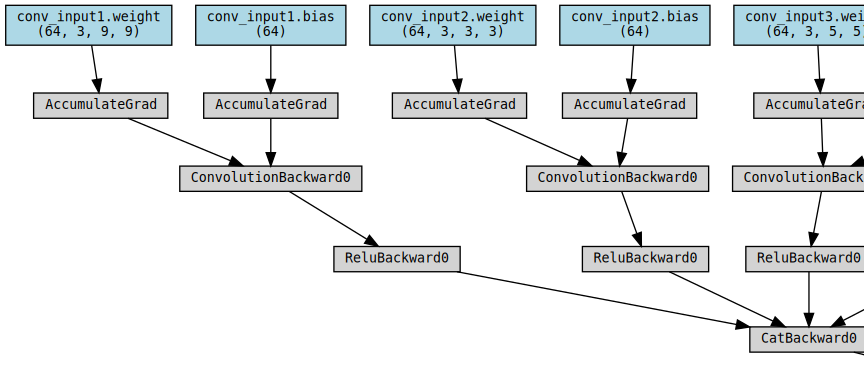

In [ ]:
'''Implement the SRCNN v2 by Anirudh + Gugan'''

model = CustomConvLayer2()
model = model.to(device = 'cuda')
summary(model, (3, 32, 32))

dummy_input = torch.randn(1,3, 32, 32)
dummy_input = dummy_input.to(device = 'cuda')

output = model(dummy_input)

graph = make_dot(output, params=dict(model.named_parameters()))
graph.render(filename='model_graph')

graph

## Implementing Loss Functions

In [ ]:
''' Initialising the VGG model and printing its layers. This gives us information
 on which layer should we use for the perceptual loss.'''

vgg = models.vgg19(pretrained=True).features.eval()
vgg.to(device = 'cuda')
summary(vgg, (3,32,32))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          36,928
              ReLU-4           [-1, 64, 32, 32]               0
         MaxPool2d-5           [-1, 64, 16, 16]               0
            Conv2d-6          [-1, 128, 16, 16]          73,856
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
              ReLU-9          [-1, 128, 16, 16]               0
        MaxPool2d-10            [-1, 128, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]         295,168
             ReLU-12            [-1, 256, 8, 8]               0
           Conv2d-13            [-1, 256, 8, 8]         590,080
             ReLU-14            [-1, 25

In [ ]:
''' Load pre-trained VGG-19 model without fully connected layers

 Includes some modifications made by Anirudh + Gugan. Swaps MSE loss for
 the VGG Perceptual Loss inspired from the SRGAN paper.
 ---
 Christian Ledig, Lucas Theis, Ferenc Husza ́r, Jose Caballero, Andrew
 Cunningham, Alejandro Acosta, Andrew Aitken, Alykhan Tejani, Johannes Totz,
 Zehan Wang,Wenzhe Shi, "Photo-Realistic Single Image Super-Resolution Using a
 Generative Adversarial Network Actions", CVPR, 2017.
 ---
 '''
for param in vgg.parameters():
    param.requires_grad = False

class VGGPerceptualLoss(nn.Module):
    def __init__(self):
        super(VGGPerceptualLoss, self).__init__()
        self.vgg = vgg

    def forward(self, x, y):
        loss = 0
        x_features = self.vgg[35](x)
        y_features = self.vgg[35](y)
        # Calculate Euclidean distance:
        loss += torch.norm(x_features - y_features)

        return loss

## Training Functions

In [ ]:
def train(model, dataloader, optimizer, criterion):

  model.train()
  running_loss = 0.0
  running_psnr = 0.0
  for bi, data in tqdm(enumerate(dataloader), total=len(dataloader)):
    image_data = data[0].to(device)
    label = data[0].to(device)

    optimizer.zero_grad()
    outputs = model(image_data)
    loss = criterion(outputs, label)

    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    batch_psnr = psnr(label, outputs)
    running_psnr += batch_psnr

  final_loss = running_loss/len(dataloader.dataset)
  final_psnr = running_psnr/len(dataloader)
  return final_loss, final_psnr

def validate(model, dataloader, epoch, criterion, output_dir):
  model.eval()
  running_loss = 0.0
  running_psnr = 0.0

  with torch.no_grad():
    for bi, data in tqdm(enumerate(dataloader), total=len(dataloader)):
      image_data = data[0].to(device)
      label = data[1].to(device)

      outputs = model(image_data)
      loss = criterion(outputs, label)

      running_loss += loss.item()
      batch_psnr = psnr(label, outputs)
      running_psnr += batch_psnr

      # For saving the batch samples for the validation results
      # every epoch.
      if SAVE_VALIDATION_RESULTS and (epoch%10==0):
        save_validation_results(outputs, epoch, bi, output_dir)

    final_loss = running_loss/len(dataloader.dataset)
    final_psnr = running_psnr/len(dataloader)
    return final_loss, final_psnr

In [ ]:
def start_training(model, epochs, optimizer, criterion, train_csv_file, valid_csv_file, output_dir):

  dataset_train, dataset_valid = get_datasets(train_csv_file,valid_csv_file)

  train_loader, valid_loader = get_dataloaders(dataset_train, dataset_valid)
  print(f"Training samples: {len(dataset_train)}")
  print(f"Validation samples: {len(dataset_valid)}")

  train_loss, val_loss = [], []
  train_psnr, val_psnr = [], []
  start = time.time()
  for epoch in range(epochs):
    train_epoch_loss, train_epoch_psnr = train(model, train_loader, optimizer, criterion)
    val_epoch_loss, val_epoch_psnr = validate(model, valid_loader, epoch+1, criterion, output_dir)
    print(f"Train PSNR: {train_epoch_psnr:.3f}")
    print(f"Val PSNR: {val_epoch_psnr:.3f}")

    train_loss.append(train_epoch_loss)
    train_psnr.append(train_epoch_psnr)
    val_loss.append(val_epoch_loss)
    val_psnr.append(val_epoch_psnr)

    # Save model with all information every 10 epochs. Can be used
    # resuming training.
    if (epoch+1) % 10 == 0:
        save_model(epoch, model, optimizer, criterion, output_dir)
    # Save the model state dictionary only every epoch. Small size,
    # can be used for inference.
    save_model_state(model, output_dir)
    # Save the PSNR and loss plots every epoch.
    save_plot(train_loss, val_loss, train_psnr, val_psnr, output_dir)

  end = time.time()
  print(f"Finished training in: {((end-start)/60):.3f} minutes")

In [ ]:
epochs = 10
lr = 0.001
device = 'cuda' if torch.cuda.is_available() else 'cpu'

SAVE_VALIDATION_RESULTS = True

## Training the Baseline SRCNN with MSE Loss

In [ ]:
model = CustomConvLayer().to(device)
summary(model,(3,32,32))
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

train_csv_file = '/content/train_data_5_Imgs_patched.csv'
valid_csv_file = '/content/test_data_50_Imgs.csv'
output_dir = 'output_SRCNN_MSE_loss'

start_training(model, epochs, optimizer, criterion, train_csv_file, valid_csv_file, output_dir)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]          15,616
            Conv2d-2           [-1, 32, 32, 32]           2,080
            Conv2d-3            [-1, 3, 32, 32]           2,403
Total params: 20,099
Trainable params: 20,099
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.77
Params size (MB): 0.08
Estimated Total Size (MB): 0.86
----------------------------------------------------------------
Training samples: 68400
Validation samples: 50


100%|██████████| 50/50 [00:17<00:00,  2.88it/s]


Train PSNR: 25.870
Val PSNR: 29.400
Saving model...


100%|██████████| 50/50 [00:17<00:00,  2.89it/s]


Train PSNR: 33.217
Val PSNR: 29.102
Saving model...


100%|██████████| 50/50 [00:16<00:00,  3.08it/s]


Train PSNR: 35.446
Val PSNR: 30.863
Saving model...


100%|██████████| 50/50 [00:16<00:00,  3.08it/s]


Train PSNR: 36.673
Val PSNR: 30.926
Saving model...


100%|██████████| 50/50 [00:16<00:00,  3.06it/s]


Train PSNR: 37.298
Val PSNR: 31.241
Saving model...


100%|██████████| 50/50 [00:16<00:00,  2.95it/s]


Train PSNR: 38.608
Val PSNR: 31.088
Saving model...


100%|██████████| 50/50 [00:16<00:00,  3.02it/s]


Train PSNR: 39.388
Val PSNR: 30.641
Saving model...


100%|██████████| 50/50 [00:17<00:00,  2.86it/s]


Train PSNR: 39.645
Val PSNR: 31.371
Saving model...


100%|██████████| 50/50 [00:16<00:00,  3.03it/s]


Train PSNR: 40.555
Val PSNR: 31.627
Saving model...


100%|██████████| 50/50 [01:27<00:00,  1.75s/it]


Train PSNR: 40.986
Val PSNR: 31.781
Saving model...
Finished training in: 12.297 minutes


In [ ]:
!zip -r '/content/output_SRCNN_MSE_loss.zip' '/content/output_SRCNN_MSE_loss'

## Training the SRCNN with VGG Based Perceptual Loss

In [ ]:
model = CustomConvLayer().to(device)
summary(model,(3,32,32))
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = VGGPerceptualLoss()

train_csv_file = '/content/train_data_5_Imgs_patched.csv'
valid_csv_file = '/content/test_data_50_Imgs.csv'
output_dir = 'output_SRCNN_VGG_loss'

start_training(model, epochs, optimizer, criterion, train_csv_file, valid_csv_file, output_dir)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]          15,616
            Conv2d-2           [-1, 32, 32, 32]           2,080
            Conv2d-3            [-1, 3, 32, 32]           2,403
Total params: 20,099
Trainable params: 20,099
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.77
Params size (MB): 0.08
Estimated Total Size (MB): 0.86
----------------------------------------------------------------
Training samples: 68400
Validation samples: 50


100%|██████████| 50/50 [00:18<00:00,  2.75it/s]


Train PSNR: 27.411
Val PSNR: 29.314
Saving model...


100%|██████████| 50/50 [00:16<00:00,  3.05it/s]


Train PSNR: 34.367
Val PSNR: 29.474
Saving model...


100%|██████████| 50/50 [00:16<00:00,  3.02it/s]


Train PSNR: 36.424
Val PSNR: 30.902
Saving model...


100%|██████████| 50/50 [00:16<00:00,  3.04it/s]


Train PSNR: 37.993
Val PSNR: 29.794
Saving model...


100%|██████████| 50/50 [00:16<00:00,  2.99it/s]


Train PSNR: 37.608
Val PSNR: 30.727
Saving model...


100%|██████████| 50/50 [00:16<00:00,  3.00it/s]


Train PSNR: 38.173
Val PSNR: 31.454
Saving model...


100%|██████████| 50/50 [00:16<00:00,  3.08it/s]


Train PSNR: 40.846
Val PSNR: 31.319
Saving model...


100%|██████████| 50/50 [00:17<00:00,  2.92it/s]


Train PSNR: 38.973
Val PSNR: 31.435
Saving model...


100%|██████████| 50/50 [00:16<00:00,  2.96it/s]


Train PSNR: 41.870
Val PSNR: 30.636
Saving model...


100%|██████████| 50/50 [01:26<00:00,  1.73s/it]


Train PSNR: 41.583
Val PSNR: 31.238
Saving model...
Finished training in: 12.559 minutes


In [ ]:
!zip -r '/content/output_SRCNN_VGG_loss.zip' '/content/output_SRCNN_VGG_loss'

## Training SRCNN Model V2 with parallel input Convolutions and VGG Perceptual loss

In [ ]:
model = CustomConvLayer2().to(device)
summary(model,(3,32,32))
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = VGGPerceptualLoss()

train_csv_file = '/content/train_data_5_Imgs_patched.csv'
valid_csv_file = '/content/test_data_50_Imgs.csv'
output_dir = 'output_SRCNN_v2_VGG_loss'

start_training(model, epochs, optimizer, criterion, train_csv_file, valid_csv_file, output_dir)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]          15,616
            Conv2d-2           [-1, 64, 32, 32]           1,792
            Conv2d-3           [-1, 64, 32, 32]           4,864
            Conv2d-4           [-1, 64, 32, 32]           9,472
            Conv2d-5           [-1, 32, 32, 32]           8,224
            Conv2d-6            [-1, 3, 32, 32]           2,403
Total params: 42,371
Trainable params: 42,371
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 2.27
Params size (MB): 0.16
Estimated Total Size (MB): 2.45
----------------------------------------------------------------
Training samples: 68400
Validation samples: 50


100%|██████████| 50/50 [00:20<00:00,  2.42it/s]


Train PSNR: 31.438
Val PSNR: 30.003
Saving model...


100%|██████████| 50/50 [00:23<00:00,  2.09it/s]


Train PSNR: 38.369
Val PSNR: 31.351
Saving model...


100%|██████████| 50/50 [00:20<00:00,  2.45it/s]


Train PSNR: 39.983
Val PSNR: 31.392
Saving model...


100%|██████████| 50/50 [00:18<00:00,  2.67it/s]


Train PSNR: 40.233
Val PSNR: 31.537
Saving model...


100%|██████████| 50/50 [00:19<00:00,  2.63it/s]


Train PSNR: 42.965
Val PSNR: 31.681
Saving model...


100%|██████████| 50/50 [00:18<00:00,  2.68it/s]


Train PSNR: 43.609
Val PSNR: 30.952
Saving model...


100%|██████████| 50/50 [00:20<00:00,  2.39it/s]


Train PSNR: 42.040
Val PSNR: 31.554
Saving model...


100%|██████████| 50/50 [00:18<00:00,  2.67it/s]


Train PSNR: 44.208
Val PSNR: 31.586
Saving model...


100%|██████████| 50/50 [00:18<00:00,  2.77it/s]


Train PSNR: 43.304
Val PSNR: 31.512
Saving model...


100%|██████████| 50/50 [01:39<00:00,  1.99s/it]


Train PSNR: 45.027
Val PSNR: 31.673
Saving model...
Finished training in: 14.823 minutes


In [ ]:
!zip -r '/content/output_SRCNN_v2_VGG_loss.zip' '/content/output_SRCNN_v2_VGG_loss'